In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import numpy as np


import matplotlib.pyplot as plt

from PIL import Image

import os
import glob


from MyDataLoader import ShuffleDataLoader
from FileReader import get_picture_tensors
from MyModels import SimpleCNN
from ModelEvaluation import eval_model


In [2]:
# data params
n_classes = 50
required_train_imgs = 10
required_test_imgs = 1

In [ ]:
root_dir = "dataset_chat_downscale_no_background"
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes, 
                                                              required_train_imgs=required_train_imgs, 
                                                              required_test_imgs=required_test_imgs)

In [4]:
# params du modèle, essayer avec gridsearch (idéalement Randomized pour ne pas prendre énormément de temps), avec une bonne machine durant la nuit ou qqch
# faudrait idéalement logger les performances selon chaque combination de params pour s'amuser
num_epochs = 6
batch_size = 8
learning_rate = 1e-3
momentum = 0.5
weight_decay = 1e-5 

model = SimpleCNN(n_classes)
model.train()
train_dataset = ShuffleDataLoader(train_images, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataset = ShuffleDataLoader(val_images, val_labels)


criterion = nn.CrossEntropyLoss()
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(params, lr = learning_rate)

# Gossage sur les params potentiel
# criterion = nn.CrossEntropyLoss(reduction = 'sum')
# criterion = nn.CrossEntropyLoss(reduction = 'none')
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(params, lr = learning_rate, weight_decay = weight_decay)
# optimizer = optim.SGD(params, lr = learning_rate, momentum = momentum)   

accuracy_at_each_epoch = []
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    accuracy_at_each_epoch.append(eval_model(model, val_dataset))
    
print('Training and evaluation finished.')

Accuracy on validation dataset: 54.35%
Accuracy on validation dataset: 80.43%
Accuracy on validation dataset: 89.13%
Accuracy on validation dataset: 95.65%
Accuracy on validation dataset: 95.65%
Accuracy on validation dataset: 93.48%
Training and evaluation finished.


Text(0, 0.5, 'Accuracy (%)')

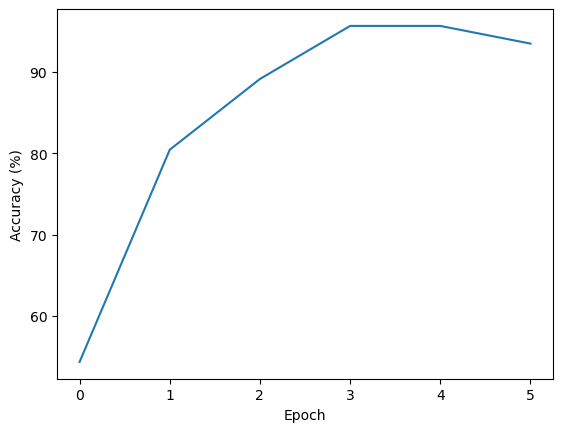

In [5]:
plt.plot(accuracy_at_each_epoch)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

In [88]:
root_dir = "dataset_chat_downscale"
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes,
                                               required_train_imgs=required_test_imgs,
                                               required_test_imgs=required_test_imgs)

Chargement de dataset_chat_downscale\0001  ->  3/17 images
Chargement de dataset_chat_downscale\0002  ->  3/20 images
Chargement de dataset_chat_downscale\0003  ->  3/15 images
Chargement de dataset_chat_downscale\0004  ->  3/56 images
Chargement de dataset_chat_downscale\0005  ->  3/41 images
Chargement de dataset_chat_downscale\0006  ->  3/40 images
Chargement de dataset_chat_downscale\0007  ->  3/41 images
Chargement de dataset_chat_downscale\0008  ->  3/18 images
Chargement de dataset_chat_downscale\0009  ->  3/13 images
Chargement de dataset_chat_downscale\0010  ->  3/36 images
Chargement de dataset_chat_downscale\0011  ->  3/26 images
Chargement de dataset_chat_downscale\0012  ->  3/17 images
Chargement de dataset_chat_downscale\0014  ->  3/16 images
Chargement de dataset_chat_downscale\0015  ->  3/53 images
Chargement de dataset_chat_downscale\0016  ->  3/32 images
Chargement de dataset_chat_downscale\0017  ->  3/61 images
Chargement de dataset_chat_downscale\0018  ->  3/54 imag

In [89]:
# array of 10 zeros
index = np.zeros(len(test_images))
score = np.zeros(len(test_images))
for i in range(len(test_images)-1, 0, -1):
    test_images = test_images[:i]
    test_labels = test_labels[:i]
    test_dataset = ShuffleDataLoader(test_images, test_labels)
    index[i] = i
    score[i] = eval_model(model, test_dataset)

Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%
Accuracy on validation dataset: 100.00%


Text(0, 0.5, 'Accuracy (%)')

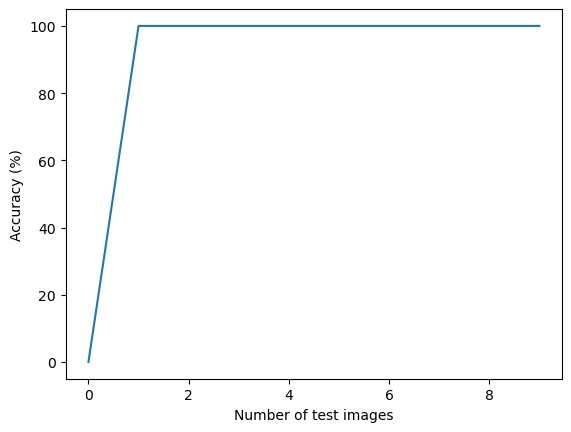

In [87]:
plt.plot(index, score)
plt.xlabel('Number of test images')
plt.ylabel('Accuracy (%)')